In [ ]:
from spacy.lang.en import English
import spacy
spacy.prefer_gpu()
from collections import Counter
import csv
import config
import tensorflow as tf
import numpy as np
import pandas as pd
import random as rnd
import subprocess
import os
import nltk
from nltk.corpus import stopwords
import re
import string
from collections import OrderedDict, defaultdict
from sklearn.linear_model import LogisticRegression
import fnmatch
#from tensorflow.keras.preprocessing.text import Tokenizer
from src.CustomTokenizer import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
import json
from tqdm import tqdm
from data_processing.preprocessing import get_dataset_text, get_word_index_list, write_index_to_file, read_index_as_string

## Load Training set

In [3]:
print("Loading training file from path: ", config.config_io.get('pan_19_processed_train'))
training_data = pd.read_csv(config.config_io.get('pan_19_processed_train'))
training_data.shape

Loading training file from path:  /home/sukanya/PhD/Datasets/PAN SCD/pan19-style-change-detection/processed/train.csv


(18961, 5)

In [5]:
training_data.head()

,problem,author_1,author_2,para1_text,para2_text
0,problem-1543.txt,A1,A1,Given an alphabet $\Sigma$ of size $k$ and two...,"\nThe paper ""Algorithmic Meta Theorems for Cir..."
1,problem-631.txt,A1,A3,"\nInstead of an actual GPS device, I would rec...","In the end, a seat post pump probably has the ..."
2,problem-631.txt,A3,A2,"In the end, a seat post pump probably has the ...",\nThanks for the help. Finally what I needed t...
3,problem-631.txt,A2,A1,\nThanks for the help. Finally what I needed t...,"\nIt might sound weird, but if you're finding ..."
4,problem-631.txt,A1,A2,"\nIt might sound weird, but if you're finding ...",This is a bit weird question. I bought a Speci...


In [4]:
training_data.columns

Index(['problem', 'author_1', 'author_2', 'para1_text', 'para2_text'], dtype='object')

## Load Testing set

In [6]:
print("Loading testing file from path: ", config.config_io.get('pan_19_processed_test'))
testing_data = pd.read_csv(config.config_io.get('pan_19_processed_test'))
testing_data.shape

Loading testing file from path:  /home/sukanya/PhD/Datasets/PAN SCD/pan19-style-change-detection/processed/test.csv


(9538, 5)

In [7]:
testing_data.head()

,problem,author_1,author_2,para1_text,para2_text
0,problem-631.txt,A1,A1,"Update\nTurns out the fuel pump, filter and re...",The door lock/unlock relays are built into the...
1,problem-631.txt,A1,A1,The door lock/unlock relays are built into the...,\nThe knuckle is the part the spindle attaches...
2,problem-631.txt,A1,A1,\nThe knuckle is the part the spindle attaches...,You would have to set the scope to the scale o...
3,problem-631.txt,A1,A1,You would have to set the scope to the scale o...,\nCheck for an exhaust leak before or right af...
4,problem-631.txt,A1,A1,\nCheck for an exhaust leak before or right af...,"Yes, a p0340 code can cause a no start as the ..."


## Load the feature set files
We are doing it manually now for greater control. In the future, we must automate to read the files directly form the directory.

In [8]:
# index files

feature_set_files = { 'opt1':
['/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/50word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/100word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/150word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/200word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/250word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/300word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/350word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/400word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/450word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/500word_list.txt'],
                    'opt2':
['/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt2/50word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt2/100word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt2/150word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt2/200word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt2/250word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt2/300word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt2/350word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt2/400word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt2/450word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt2/500word_list.txt'],
                    'opt3':
['/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt3/50word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt3/100word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt3/150word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt3/200word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt3/250word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt3/300word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt3/350word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt3/400word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt3/450word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt3/500word_list.txt'],
                    'opt4':
['/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt4/50word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt4/100word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt4/150word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt4/200word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt4/250word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt4/300word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt4/350word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt4/400word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt4/450word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt4/500word_list.txt']}


In [9]:
#nlp = English()
nlp = spacy.load("en_core_web_sm")

In [10]:
nlp.pipeline

[('tagger', <spacy.pipeline.pipes.Tagger at 0x7fc9917a1130>),
 ('parser', <spacy.pipeline.pipes.DependencyParser at 0x7fca60666100>),
 ('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x7fc9919c1fa0>)]

['a', 'very', 'large', 'line', 'this', 'is', 'i', 'do', "n't", 'know', 'how', 'this', 'works', 'yet', '!', 'god', 'save', 'me', '!', '!']


In [11]:
# takes micro seconds 90.7 µs ± 962 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each), 100 times faster than below loop
def custom_analyzer(text):
    #doc = nlp(text.lower())
    doc = list(nlp.pipe([text.lower()], disable=["tagger", "parser","ner"]))[0]
    return [t.text for t in doc]

print(custom_analyzer("A very large line this is I don't know how this works yet! God Save me!!"))

['a', 'very', 'large', 'line', 'this', 'is', 'i', 'do', "n't", 'know', 'how', 'this', 'works', 'yet', '!', 'god', 'save', 'me', '!', '!']


/home/sukanya/PycharmProjects/SiameseNetworkTensorflow/src/baseline_with_Spacy/word_index/opt1/50word_list.txt
. ,   's n't    like one 'm get time urllink know really go well would     got think people good day back going see much love went today could want nt even life 've way 'll still say last things work make first new something right us ca


In [14]:
# takes mili seconds 4.23 ms ± 124 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
'''def custom_analyzer(text):
    doc = nlp(text.lower())
    #doc = list(nlp.pipe([text.lower()], disable=["tagger", "parser","ner"]))[0]
    return [t.text for t in doc]

print(custom_analyzer("A very large line this is I don't know how this works yet! God Save me!!"))'''

{'opt1': ['/home/sukanya/PycharmProjects/SiameseNetworkTensorflow/src/baseline_with_Spacy/word_index/opt1/50word_list.txt',
  '/home/sukanya/PycharmProjects/SiameseNetworkTensorflow/src/baseline_with_Spacy/word_index/opt1/100word_list.txt',
  '/home/sukanya/PycharmProjects/SiameseNetworkTensorflow/src/baseline_with_Spacy/word_index/opt1/150word_list.txt',
  '/home/sukanya/PycharmProjects/SiameseNetworkTensorflow/src/baseline_with_Spacy/word_index/opt1/200word_list.txt',
  '/home/sukanya/PycharmProjects/SiameseNetworkTensorflow/src/baseline_with_Spacy/word_index/opt1/250word_list.txt',
  '/home/sukanya/PycharmProjects/SiameseNetworkTensorflow/src/baseline_with_Spacy/word_index/opt1/300word_list.txt',
  '/home/sukanya/PycharmProjects/SiameseNetworkTensorflow/src/baseline_with_Spacy/word_index/opt1/350word_list.txt',
  '/home/sukanya/PycharmProjects/SiameseNetworkTensorflow/src/baseline_with_Spacy/word_index/opt1/400word_list.txt',
  '/home/sukanya/PycharmProjects/SiameseNetworkTensorflow

In [12]:
feature_set_files

{'opt1': ['/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/50word_list.txt',
  '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/100word_list.txt',
  '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/150word_list.txt',
  '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/200word_list.txt',
  '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/250word_list.txt',
  '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/300word_list.txt',
  '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/350word_list.txt',
  '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/400word_list.txt',
  '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/450word_list.txt',
  '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/500word_list.txt'],
 'opt2': ['/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt2/50word_list.txt',
  '/home/sukanya/PycharmProjects/SiameseNNPAN/src/

In [13]:
metrics = {}
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

for key in list(feature_set_files.keys()):
    print(key)
    temp_metrics_dict={}
    vocab_files = []
    training_acc = []
    training_loss = []
    validation_loss = []
    validation_acc = []
    testing_acc= []
    testing_loss = []
    vocab_size_list = []
    print(key, feature_set_files.get(key))
    for feature_file in feature_set_files.get(key):
        word_tokenizer = Tokenizer(analyzer=custom_analyzer)
        with open(feature_file, "r") as f:
            word_index_str = f.read().replace('\n', '')
        print(word_index_str)
        word_tokenizer.fit_on_texts([word_index_str])
        len_train = len(training_data)
        # define the generators
        from src.DataGenerator import DataGenerator
        training_generator = DataGenerator(training_data.iloc[0:int(0.8*len_train)], tokenizer=word_tokenizer, batch_size=16)
        validation_generator = DataGenerator(training_data.iloc[int(0.8*len_train):], tokenizer=word_tokenizer, batch_size=16)
        testing_generator = DataGenerator(testing_data, tokenizer=word_tokenizer, batch_size=16)

        # this is a hack for "'DataGenerator' object has no attribute 'index'". It turns out that on_epoch_end creates the index that is used
        training_generator.on_epoch_end()
        validation_generator.on_epoch_end()
        testing_generator.on_epoch_end()
        # parameters
        num_classes =2
        num_features = 1

        # define model
        model = Sequential()
        model.add(Dense(50, input_dim=num_features, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(num_classes, activation='softmax'))

        # compile model
        opt = SGD(lr=0.01, momentum=0.9)
        #model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        # fit model
        history = model.fit(training_generator, validation_data=validation_generator, verbose=1, batch_size=16, 
                             epochs=30, steps_per_epoch=100, callbacks=[callback]) #validation_steps=100,

        history_dict = history.history
        vocab_files.append(feature_file.split('/')[-1])
        json.dump(history_dict, open("history_" + key + "_" +feature_file.split('/')[-1], 'w'))
        loss = history_dict['loss'][-1]
        training_loss.append(loss)
        acc = history_dict['accuracy'][-1]
        training_acc.append(acc)
        val_loss = history_dict['val_loss'][-1]
        validation_loss.append(val_loss)
        val_acc = history_dict['val_accuracy'][-1]
        validation_acc.append(val_acc)
        test_loss, test_acc = model.evaluate(testing_generator)
        testing_acc.append(test_acc)
        testing_loss.append(test_loss)
        vocab_size_list.append(feature_file.split('/')[-1])
        print("training acc: ", acc, ", training loss: ", loss, ", val acc: ", val_acc, ", val loss: ", val_loss,", test acc: ", test_acc, ", test loss: ", test_loss)
        print()
    temp_metrics_dict={'vocab_size':vocab_size_list,
        'training_loss' : training_loss,
         'training_acc': training_acc,
         'validation_loss': validation_loss,
         'validation_acc': validation_acc,
         'testing_loss':testing_loss,
         'testing_acc':testing_acc}
    json.dump(temp_metrics_dict, open("total_history_" + key, 'w'))
    metrics[key] = temp_metrics_dict
    

opt1
opt1 ['/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/50word_list.txt', '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/100word_list.txt', '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/150word_list.txt', '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/200word_list.txt', '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/250word_list.txt', '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/300word_list.txt', '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/350word_list.txt', '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/400word_list.txt', '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/450word_list.txt', '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/500word_list.txt']
the to a  of and is i in you that it $ for   this be with as on are have if not can or but your 's n't would an do so from there will at by they   one my which 

100/100 [==============================] - 8s 79ms/step - loss: 0.7486 - accuracy: 0.5781 - val_loss: 0.7018 - val_accuracy: 0.4889
Epoch 2/30
100/100 [==============================] - 8s 79ms/step - loss: 0.7027 - accuracy: 0.5163 - val_loss: 0.6967 - val_accuracy: 0.4982
Epoch 3/30
100/100 [==============================] - 8s 81ms/step - loss: 0.6949 - accuracy: 0.5437 - val_loss: 0.6925 - val_accuracy: 0.5562
Epoch 4/30
100/100 [==============================] - 8s 79ms/step - loss: 0.6948 - accuracy: 0.5625 - val_loss: 0.6897 - val_accuracy: 0.5770
Epoch 5/30
100/100 [==============================] - 8s 80ms/step - loss: 0.6868 - accuracy: 0.5956 - val_loss: 0.6874 - val_accuracy: 0.5794
Epoch 6/30
100/100 [==============================] - 8s 80ms/step - loss: 0.6843 - accuracy: 0.5950 - val_loss: 0.6842 - val_accuracy: 0.5794
Epoch 7/30
100/100 [==============================] - 8s 78ms/step - loss: 0.6758 - accuracy: 0.6100 - val_loss: 0.6833 - val_accuracy: 0.5794
Epoch 8/30

Epoch 16/30
596/596 [==============================] - 14s 24ms/step - loss: 0.6711 - accuracy: 0.5877
training acc:  0.5699999928474426 , training loss:  0.6689412593841553 , val acc:  0.5793776512145996 , val loss:  0.6761950254440308 , test acc:  0.5876677632331848 , test loss:  0.6711481809616089

the to a  of and is i in you that it $ for   this be with as on are have if not can or but your 's n't would an do so from there will at by they   one my which what all more we some when then like was use / has just any also about get no how only could other time out does them than up need should way using same make want 'm their where work - because here see first two very into think even know these me 1 example may each people = different most used might much something now question 've he such am after well case its 're set good however number 2 been find try new problem say being since really many take both still possible data did answer those right another code who too between why wer

Epoch 1/30
100/100 [==============================] - 8s 80ms/step - loss: 0.6996 - accuracy: 0.5188 - val_loss: 0.6879 - val_accuracy: 0.5836
Epoch 2/30
100/100 [==============================] - 8s 80ms/step - loss: 0.6878 - accuracy: 0.5456 - val_loss: 0.6798 - val_accuracy: 0.5794
Epoch 3/30
100/100 [==============================] - 8s 81ms/step - loss: 0.6819 - accuracy: 0.5644 - val_loss: 0.6835 - val_accuracy: 0.5794
Epoch 4/30
100/100 [==============================] - 8s 81ms/step - loss: 0.6883 - accuracy: 0.5344 - val_loss: 0.6766 - val_accuracy: 0.5733
Epoch 5/30
100/100 [==============================] - 8s 79ms/step - loss: 0.6817 - accuracy: 0.5756 - val_loss: 0.6784 - val_accuracy: 0.5876
Epoch 6/30
100/100 [==============================] - 8s 77ms/step - loss: 0.6729 - accuracy: 0.5919 - val_loss: 0.6809 - val_accuracy: 0.5794
Epoch 7/30
100/100 [==============================] - 8s 77ms/step - loss: 0.6795 - accuracy: 0.5875 - val_loss: 0.6724 - val_accuracy: 0.5641

596/596 [==============================] - 14s 24ms/step - loss: 0.6701 - accuracy: 0.5877
training acc:  0.5837500095367432 , training loss:  0.6713783740997314 , val acc:  0.5793776512145996 , val loss:  0.6756013631820679 , test acc:  0.5876677632331848 , test loss:  0.6700776219367981

opt2
opt2 ['/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt2/50word_list.txt', '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt2/100word_list.txt', '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt2/150word_list.txt', '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt2/200word_list.txt', '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt2/250word_list.txt', '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt2/300word_list.txt', '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt2/350word_list.txt', '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt2/400word_list.txt', '/home/sukanya/PycharmProjects/Siam

596/596 [==============================] - 14s 24ms/step - loss: 0.6710 - accuracy: 0.5877
training acc:  0.5556250214576721 , training loss:  0.6815797686576843 , val acc:  0.5793776512145996 , val loss:  0.6758808493614197 , test acc:  0.5876677632331848 , test loss:  0.6709553599357605

the . , to a  of and is i in you that it $ for   this be with as on are have if not can or but your 's n't would an do so from there will at by they   one my which what all more we some when then like was use / has just any also about get no how only could other time out does them than up need should way using same make want 'm their where work - because here see first two very into think even know these me 1 example may each people = different most used might much something now question 've he such am after well case its 're set good however number 2 been find try new problem say being since really many take both still possible data did answer those right another code who too between why were while 

Epoch 1/30
100/100 [==============================] - 8s 76ms/step - loss: 0.6898 - accuracy: 0.5869 - val_loss: 0.6885 - val_accuracy: 0.5794
Epoch 2/30
100/100 [==============================] - 8s 77ms/step - loss: 0.6953 - accuracy: 0.5163 - val_loss: 0.6861 - val_accuracy: 0.5794
Epoch 3/30
100/100 [==============================] - 8s 79ms/step - loss: 0.6909 - accuracy: 0.5456 - val_loss: 0.6857 - val_accuracy: 0.5794
Epoch 4/30
100/100 [==============================] - 8s 77ms/step - loss: 0.6877 - accuracy: 0.5612 - val_loss: 0.6874 - val_accuracy: 0.5854
Epoch 5/30
100/100 [==============================] - 8s 77ms/step - loss: 0.6760 - accuracy: 0.6169 - val_loss: 0.6826 - val_accuracy: 0.5794
Epoch 6/30
100/100 [==============================] - 8s 77ms/step - loss: 0.6866 - accuracy: 0.5800 - val_loss: 0.6796 - val_accuracy: 0.5794
Epoch 7/30
100/100 [==============================] - 8s 77ms/step - loss: 0.6858 - accuracy: 0.5562 - val_loss: 0.6787 - val_accuracy: 0.5794

Epoch 14/30
100/100 [==============================] - 8s 78ms/step - loss: 0.6791 - accuracy: 0.5575 - val_loss: 0.6713 - val_accuracy: 0.5876
Epoch 15/30
100/100 [==============================] - 8s 80ms/step - loss: 0.6762 - accuracy: 0.5575 - val_loss: 0.6695 - val_accuracy: 0.5762
Epoch 16/30
100/100 [==============================] - 8s 79ms/step - loss: 0.6691 - accuracy: 0.5950 - val_loss: 0.6689 - val_accuracy: 0.5630
Epoch 17/30
100/100 [==============================] - 8s 81ms/step - loss: 0.6782 - accuracy: 0.5663 - val_loss: 0.6714 - val_accuracy: 0.5794
Epoch 18/30
100/100 [==============================] - 8s 79ms/step - loss: 0.6776 - accuracy: 0.5562 - val_loss: 0.6700 - val_accuracy: 0.5791
Epoch 19/30
596/596 [==============================] - 14s 24ms/step - loss: 0.6704 - accuracy: 0.5991
training acc:  0.625 , training loss:  0.6592226624488831 , val acc:  0.5864979028701782 , val loss:  0.6710985898971558 , test acc:  0.5990981459617615 , test loss:  0.67035341

Epoch 1/30
100/100 [==============================] - 8s 78ms/step - loss: 0.6854 - accuracy: 0.5675 - val_loss: 0.6885 - val_accuracy: 0.5794
Epoch 2/30
100/100 [==============================] - 8s 79ms/step - loss: 0.6893 - accuracy: 0.5694 - val_loss: 0.6827 - val_accuracy: 0.5794
Epoch 3/30
100/100 [==============================] - 8s 79ms/step - loss: 0.6836 - accuracy: 0.5831 - val_loss: 0.6805 - val_accuracy: 0.5794
Epoch 4/30
100/100 [==============================] - 8s 79ms/step - loss: 0.6705 - accuracy: 0.6206 - val_loss: 0.6813 - val_accuracy: 0.5794
Epoch 5/30
100/100 [==============================] - 8s 80ms/step - loss: 0.6850 - accuracy: 0.5625 - val_loss: 0.6779 - val_accuracy: 0.5767
Epoch 6/30
100/100 [==============================] - 8s 78ms/step - loss: 0.6844 - accuracy: 0.5512 - val_loss: 0.6765 - val_accuracy: 0.5680
Epoch 7/30
100/100 [==============================] - 8s 80ms/step - loss: 0.6755 - accuracy: 0.5894 - val_loss: 0.6747 - val_accuracy: 0.5794

Epoch 1/30
100/100 [==============================] - 7s 74ms/step - loss: 0.6880 - accuracy: 0.5775 - val_loss: 0.6836 - val_accuracy: 0.5794
Epoch 2/30
100/100 [==============================] - 8s 78ms/step - loss: 0.6856 - accuracy: 0.5944 - val_loss: 0.6823 - val_accuracy: 0.5794
Epoch 3/30
100/100 [==============================] - 8s 76ms/step - loss: 0.6833 - accuracy: 0.5775 - val_loss: 0.6816 - val_accuracy: 0.5794
Epoch 4/30
100/100 [==============================] - 8s 76ms/step - loss: 0.6841 - accuracy: 0.5769 - val_loss: 0.6811 - val_accuracy: 0.5794
Epoch 5/30
100/100 [==============================] - 8s 76ms/step - loss: 0.6892 - accuracy: 0.5469 - val_loss: 0.6808 - val_accuracy: 0.5794
Epoch 6/30
100/100 [==============================] - 8s 76ms/step - loss: 0.6926 - accuracy: 0.5412 - val_loss: 0.6841 - val_accuracy: 0.5794
Epoch 7/30
100/100 [==============================] - 8s 76ms/step - loss: 0.6813 - accuracy: 0.5863 - val_loss: 0.6807 - val_accuracy: 0.5794

100/100 [==============================] - 8s 75ms/step - loss: 0.6817 - accuracy: 0.6144 - val_loss: 0.6806 - val_accuracy: 0.5794
Epoch 4/30
100/100 [==============================] - 8s 76ms/step - loss: 0.6783 - accuracy: 0.5975 - val_loss: 0.6794 - val_accuracy: 0.5794
Epoch 5/30
100/100 [==============================] - 8s 77ms/step - loss: 0.6764 - accuracy: 0.5781 - val_loss: 0.6788 - val_accuracy: 0.5794
Epoch 6/30
100/100 [==============================] - 8s 76ms/step - loss: 0.6933 - accuracy: 0.5381 - val_loss: 0.6807 - val_accuracy: 0.5794
Epoch 7/30
100/100 [==============================] - 8s 76ms/step - loss: 0.6766 - accuracy: 0.6131 - val_loss: 0.6780 - val_accuracy: 0.5794
Epoch 8/30
100/100 [==============================] - 8s 76ms/step - loss: 0.6778 - accuracy: 0.6087 - val_loss: 0.6770 - val_accuracy: 0.5794
Epoch 9/30
100/100 [==============================] - 8s 76ms/step - loss: 0.6733 - accuracy: 0.6069 - val_loss: 0.6763 - val_accuracy: 0.5794
Epoch 10/3

100/100 [==============================] - 8s 76ms/step - loss: 0.6798 - accuracy: 0.5981 - val_loss: 0.6820 - val_accuracy: 0.5794
Epoch 6/30
100/100 [==============================] - 8s 76ms/step - loss: 0.6886 - accuracy: 0.5644 - val_loss: 0.6833 - val_accuracy: 0.5794
Epoch 7/30
596/596 [==============================] - 14s 23ms/step - loss: 0.6816 - accuracy: 0.5877
training acc:  0.5506250262260437 , training loss:  0.6909430623054504 , val acc:  0.5793776512145996 , val loss:  0.6831066012382507 , test acc:  0.5876677632331848 , test loss:  0.6815735697746277

 $   's n't would   one like use / also get could time need way using make want 'm work - see first two think even know 1 example may people = different used might much something question 've well case 're set good however number 2 find try new problem say since really many take still possible data answer right another code go point change without value probably things page + better image let ca sure create add back url

Epoch 1/30
100/100 [==============================] - 8s 77ms/step - loss: 0.6890 - accuracy: 0.5400 - val_loss: 0.6827 - val_accuracy: 0.5941
Epoch 2/30
100/100 [==============================] - 8s 77ms/step - loss: 0.6861 - accuracy: 0.5556 - val_loss: 0.6827 - val_accuracy: 0.6057
Epoch 3/30
100/100 [==============================] - 8s 76ms/step - loss: 0.6792 - accuracy: 0.5794 - val_loss: 0.6815 - val_accuracy: 0.5794
Epoch 4/30
100/100 [==============================] - 8s 78ms/step - loss: 0.6855 - accuracy: 0.5819 - val_loss: 0.6809 - val_accuracy: 0.5794
Epoch 5/30
100/100 [==============================] - 8s 77ms/step - loss: 0.6782 - accuracy: 0.5919 - val_loss: 0.6797 - val_accuracy: 0.5794
Epoch 6/30
100/100 [==============================] - 8s 77ms/step - loss: 0.6831 - accuracy: 0.5925 - val_loss: 0.6806 - val_accuracy: 0.5794
Epoch 7/30
100/100 [==============================] - 8s 79ms/step - loss: 0.6719 - accuracy: 0.6212 - val_loss: 0.6779 - val_accuracy: 0.5794

Epoch 15/30
100/100 [==============================] - 7s 74ms/step - loss: 0.6758 - accuracy: 0.6075 - val_loss: 0.6794 - val_accuracy: 0.5794
Epoch 16/30
100/100 [==============================] - 8s 76ms/step - loss: 0.6882 - accuracy: 0.5375 - val_loss: 0.6822 - val_accuracy: 0.5538
Epoch 17/30
100/100 [==============================] - 8s 76ms/step - loss: 0.6873 - accuracy: 0.5575 - val_loss: 0.6787 - val_accuracy: 0.5794
Epoch 18/30
100/100 [==============================] - 8s 76ms/step - loss: 0.6820 - accuracy: 0.5869 - val_loss: 0.6799 - val_accuracy: 0.5794
Epoch 19/30
100/100 [==============================] - 8s 77ms/step - loss: 0.6849 - accuracy: 0.5850 - val_loss: 0.6797 - val_accuracy: 0.5794
Epoch 20/30
596/596 [==============================] - 14s 23ms/step - loss: 0.6795 - accuracy: 0.5877
training acc:  0.5768749713897705 , training loss:  0.678435206413269 , val acc:  0.5793776512145996 , val loss:  0.6834168434143066 , test acc:  0.5876677632331848 , test loss:

Epoch 6/30
100/100 [==============================] - 8s 77ms/step - loss: 0.6795 - accuracy: 0.5788 - val_loss: 0.6790 - val_accuracy: 0.5506
Epoch 7/30
100/100 [==============================] - 8s 75ms/step - loss: 0.6798 - accuracy: 0.5619 - val_loss: 0.6765 - val_accuracy: 0.5794
Epoch 8/30
100/100 [==============================] - 8s 76ms/step - loss: 0.6803 - accuracy: 0.5744 - val_loss: 0.6763 - val_accuracy: 0.5794
Epoch 9/30
100/100 [==============================] - 8s 77ms/step - loss: 0.6696 - accuracy: 0.6094 - val_loss: 0.6822 - val_accuracy: 0.5794
Epoch 10/30
100/100 [==============================] - 8s 76ms/step - loss: 0.6772 - accuracy: 0.5788 - val_loss: 0.6791 - val_accuracy: 0.5559
Epoch 11/30
596/596 [==============================] - 14s 24ms/step - loss: 0.6734 - accuracy: 0.5877
training acc:  0.5774999856948853 , training loss:  0.672272801399231 , val acc:  0.5793776512145996 , val loss:  0.6763840913772583 , test acc:  0.5876677632331848 , test loss:  0.

100/100 [==============================] - 8s 80ms/step - loss: 0.6703 - accuracy: 0.5919 - val_loss: 0.6760 - val_accuracy: 0.5794
Epoch 18/30
100/100 [==============================] - 8s 78ms/step - loss: 0.6795 - accuracy: 0.5800 - val_loss: 0.6785 - val_accuracy: 0.5794
Epoch 19/30
100/100 [==============================] - 8s 78ms/step - loss: 0.6771 - accuracy: 0.5763 - val_loss: 0.6790 - val_accuracy: 0.5794
Epoch 20/30
596/596 [==============================] - 14s 24ms/step - loss: 0.6832 - accuracy: 0.5633
training acc:  0.5543749928474426 , training loss:  0.6863294839859009 , val acc:  0.5588080286979675 , val loss:  0.6829063296318054 , test acc:  0.5633389353752136 , test loss:  0.6831761002540588

. ,  $   's n't would   one like use / also get could time need way using make want 'm work - see first two think even know 1 example may people = different used might much something question 've well case 're set good however number 2 find try new problem say since really man

100/100 [==============================] - 8s 76ms/step - loss: 0.6908 - accuracy: 0.5956 - val_loss: 0.6910 - val_accuracy: 0.5396
Epoch 2/30
100/100 [==============================] - 8s 77ms/step - loss: 0.6893 - accuracy: 0.5725 - val_loss: 0.6909 - val_accuracy: 0.5794
Epoch 3/30
100/100 [==============================] - 8s 78ms/step - loss: 0.6895 - accuracy: 0.5675 - val_loss: 0.6875 - val_accuracy: 0.5794
Epoch 4/30
100/100 [==============================] - 8s 78ms/step - loss: 0.6806 - accuracy: 0.5931 - val_loss: 0.6874 - val_accuracy: 0.5794
Epoch 5/30
100/100 [==============================] - 8s 79ms/step - loss: 0.6896 - accuracy: 0.5825 - val_loss: 0.6875 - val_accuracy: 0.5794
Epoch 6/30
100/100 [==============================] - 8s 76ms/step - loss: 0.6879 - accuracy: 0.5625 - val_loss: 0.6829 - val_accuracy: 0.5794
Epoch 7/30
100/100 [==============================] - 8s 76ms/step - loss: 0.6914 - accuracy: 0.5594 - val_loss: 0.6809 - val_accuracy: 0.5794
Epoch 8/30

In [14]:
json.dump(metrics, open("history/total_history_combined", 'w'))

In [68]:
df_opt1 = pd.DataFrame(metrics.get('opt1'))
df_opt2 = pd.DataFrame(metrics.get('opt2'))
df_opt3 = pd.DataFrame(metrics.get('opt3'))
df_opt4 = pd.DataFrame(metrics.get('opt4'))

In [69]:
df_opt1

,vocab_size,training_loss,training_acc,validation_loss,validation_acc,testing_loss,testing_acc
0,50word_list.txt,0.658537,0.6025,0.661470,0.599913,0.660793,0.590235
1,100word_list.txt,0.656294,0.6050,0.658305,0.594183,0.659788,0.585102


In [97]:
temp_df_1 = df_opt1.loc[df_opt1['vocab_size'] == '100word_list.txt'].copy()
temp_df_1.index= ["opt1"]
temp_df_1

,vocab_size,training_loss,training_acc,validation_loss,validation_acc,testing_loss,testing_acc
opt1,100word_list.txt,0.656294,0.605,0.658305,0.594183,0.659788,0.585102


In [98]:
temp_df_2 = df_opt2.loc[df_opt2['vocab_size'] == '100word_list.txt'].copy()
temp_df_2.index= ["opt2"]
temp_df_2

,vocab_size,training_loss,training_acc,validation_loss,validation_acc,testing_loss,testing_acc
opt2,100word_list.txt,0.630891,0.630625,0.638632,0.614187,0.6476,0.602873


In [99]:
temp_df_3 = df_opt3.loc[df_opt3['vocab_size'] == '100word_list.txt'].copy()
temp_df_3.index= ["opt3"]
temp_df_3

,vocab_size,training_loss,training_acc,validation_loss,validation_acc,testing_loss,testing_acc
opt3,100word_list.txt,0.647728,0.6125,0.650469,0.613862,0.649569,0.611586


In [100]:
temp_df_4 = df_opt4.loc[df_opt4['vocab_size'] == '100word_list.txt'].copy()
temp_df_4.index= ["opt4"]
temp_df_4

,vocab_size,training_loss,training_acc,validation_loss,validation_acc,testing_loss,testing_acc
opt4,100word_list.txt,0.615623,0.636875,0.61408,0.64814,0.616221,0.647084


In [101]:
result = pd.concat([temp_df_1,temp_df_2,temp_df_3, temp_df_4])

In [102]:
result

,vocab_size,training_loss,training_acc,validation_loss,validation_acc,testing_loss,testing_acc
opt1,100word_list.txt,0.656294,0.605000,0.658305,0.594183,0.659788,0.585102
opt2,100word_list.txt,0.630891,0.630625,0.638632,0.614187,0.647600,0.602873
opt3,100word_list.txt,0.647728,0.612500,0.650469,0.613862,0.649569,0.611586
opt4,100word_list.txt,0.615623,0.636875,0.614080,0.648140,0.616221,0.647084


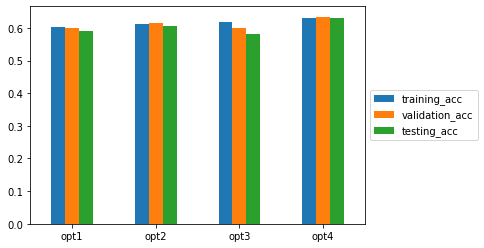

In [96]:
result[['training_acc', 'validation_acc', 'testing_acc']].plot.bar(rot=0).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

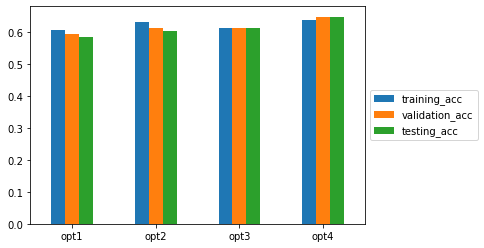

In [103]:
result[['training_acc', 'validation_acc', 'testing_acc']].plot.bar(rot=0).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))